<a href="https://colab.research.google.com/github/raynardj/python4ml/blob/master/experiments/collab_bootstrap_coldstart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tackling cold start
> Continuiong from the collab notebook

In [205]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [206]:
#hide
from fastbook import *

# Collaborative Filtering Deep Dive

One very common problem to solve is when you have a number of users and a number of products, and you want to recommend which products are most likely to be useful for which users. There are many variations of this: for example, recommending movies (such as on Netflix), figuring out what to highlight for a user on a home page, deciding what stories to show in a social media feed, and so forth. There is a general solution to this problem, called *collaborative filtering*, which works like this: look at what products the current user has used or liked, find other users that have used or liked similar products, and then recommend other products that those users have used or liked.

For example, on Netflix you may have watched lots of movies that are science fiction, full of action, and were made in the 1970s. Netflix may not know these particular properties of the films you have watched, but it will be able to see that other people that have watched the same movies that you watched also tended to watch other movies that are science fiction, full of action, and were made in the 1970s. In other words, to use this approach we don't necessarily need to know anything about the movies, except who like to watch them.

There is actually a more general class of problems that this approach can solve, not necessarily involving users and products. Indeed, for collaborative filtering we more commonly refer to *items*, rather than *products*. Items could be links that people click on, diagnoses that are selected for patients, and so forth.

The key foundational idea is that of *latent factors*. In the Netflix example, we started with the assumption that you like old, action-packed sci-fi movies. But you never actually told Netflix that you like these kinds of movies. And Netflix never actually needed to add columns to its movies table saying which movies are of these types. Still, there must be some underlying concept of sci-fi, action, and movie age, and these concepts must be relevant for at least some people's movie watching decisions.

For this chapter we are going to work on this movie recommendation problem. We'll start by getting some data suitable for a collaborative filtering model.

## A First Look at the Data

We do not have access to Netflix's entire dataset of movie watching history, but there is a great dataset that we can use, called [MovieLens](https://grouplens.org/datasets/movielens/). This dataset contains tens of millions of movie rankings (a combination of a movie ID, a user ID, and a numeric rating), although we will just use a subset of 100,000 of them for our example. If you're interested, it would be a great learning project to try and replicate this approach on the full 25-million recommendation dataset, which you can get from their website.

The dataset is available through the usual fastai function:

In [3]:
from fastai.collab import *
from fastai.tabular.all import *
path = untar_data(URLs.ML_100k)

According to the *README*, the main table is in the file *u.data*. It is tab-separated and the columns are, respectively user, movie, rating, and timestamp. Since those names are not encoded, we need to indicate them when reading the file with Pandas. Here is a way to open this table and take a look:

In [26]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=['user','movie','rating','timestamp'])
ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


Although this has all the information we need, it is not a particularly helpful way for humans to look at this data. <<movie_xtab>> shows the same data cross-tabulated into a human-friendly table.

<img alt="Crosstab of movies and users" width="632" caption="Crosstab of movies and users" id="movie_xtab" src="https://github.com/fastai/fastbook/blob/master/images/att_00040.png?raw=1">

We have selected just a few of the most popular movies, and users who watch the most movies, for this crosstab example. The empty cells in this table are the things that we would like our model to learn to fill in. Those are the places where a user has not reviewed the movie yet, presumably because they have not watched it. For each user, we would like to figure out which of those movies they might be most likely to enjoy.

If we knew for each user to what degree they liked each important category that a movie might fall into, such as genre, age, preferred directors and actors, and so forth, and we knew the same information about each movie, then a simple way to fill in this table would be to multiply this information together for each movie and use a combination. For instance, assuming these factors range between -1 and +1, with positive numbers indicating stronger matches and negative numbers weaker ones, and the categories are science-fiction, action, and old movies, then we could represent the movie *The Last Skywalker* as:

In [5]:
last_skywalker = np.array([0.98,0.9,-0.9])

Here, for instance, we are scoring *very science-fiction* as 0.98, *very action* as 0.9, and *very not old* as -0.9. We could represent a user who likes modern sci-fi action movies as:

In [6]:
user1 = np.array([0.9,0.8,-0.6])

and we can now calculate the match between this combination:

In [7]:
(user1*last_skywalker).sum()

2.1420000000000003

When we multiply two vectors together and add up the results, this is known as the *dot product*. It is used a lot in machine learning, and forms the basis of matrix multiplication. We will be looking a lot more at matrix multiplication and dot products in <<chapter_foundations>>.

> jargon: dot product: The mathematical operation of multiplying the elements of two vectors together, and then summing up the result.

On the other hand, we might represent the movie *Casablanca* as:

In [8]:
casablanca = np.array([-0.99,-0.3,0.8])

The match between this combination is:

In [9]:
(user1*casablanca).sum()

-1.611

Since we don't know what the latent factors actually are, and we don't know how to score them for each user and movie, we should learn them.

## Learning the Latent Factors

There is surprisingly little difference between specifying the structure of a model, as we did in the last section, and learning one, since we can just use our general gradient descent approach.

Step 1 of this approach is to randomly initialize some parameters. These parameters will be a set of latent factors for each user and movie. We will have to decide how many to use. We will discuss how to select this shortly, but for illustrative purposes let's use 5 for now. Because each user will have a set of these factors and each movie will have a set of these factors, we can show these randomly initialized values right next to the users and movies in our crosstab, and we can then fill in the dot products for each of these combinations in the middle. For example, <<xtab_latent>> shows what it looks like in Microsoft Excel, with the top-left cell formula displayed as an example.

<img alt="Latent factors with crosstab" width="900" caption="Latent factors with crosstab" id="xtab_latent" src="https://github.com/fastai/fastbook/blob/master/images/att_00041.png?raw=1">

Step 2 of this approach is to calculate our predictions. As we've discussed, we can do this by simply taking the dot product of each movie with each user. If, for instance, the first latent user factor represents how much the user likes action movies and the first latent movie factor represents if the movie has a lot of action or not, the product of those will be particularly high if either the user likes action movies and the movie has a lot of action in it or the user doesn't like action movies and the movie doesn't have any action in it. On the other hand, if we have a mismatch (a user loves action movies but the movie isn't an action film, or the user doesn't like action movies and it is one), the product will be very low.

Step 3 is to calculate our loss. We can use any loss function that we wish; let's pick mean squared error for now, since that is one reasonable way to represent the accuracy of a prediction.

That's all we need. With this in place, we can optimize our parameters (that is, the latent factors) using stochastic gradient descent, such as to minimize the loss. At each step, the stochastic gradient descent optimizer will calculate the match between each movie and each user using the dot product, and will compare it to the actual rating that each user gave to each movie. It will then calculate the derivative of this value and will step the weights by multiplying this by the learning rate. After doing this lots of times, the loss will get better and better, and the recommendations will also get better and better.

To use the usual `Learner.fit` function we will need to get our data into a `DataLoaders`, so let's focus on that now.

## Creating the DataLoaders

When showing the data, we would rather see movie titles than their IDs. The table `u.item` contains the correspondence of IDs to titles:

In [23]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


But the original data has genre columns

In [21]:
# !head -n100 {path/"u.item"}

In [13]:
genre = pd.read_csv(path/"u.genre", sep = "|", names=["genre","idx"])
genre

,genre,idx
0,unknown,0
1,Action,1
2,Adventure,2
3,Animation,3
4,Children's,4
5,Comedy,5
6,Crime,6
7,Documentary,7
8,Drama,8
9,Fantasy,9


In [14]:
genre_map = dict(genre[["idx","genre"]].values)

In [129]:
gcolumns = list(f"genre_{v}" for v in genre_map.values())
movies_full = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1,2,*range(5,5+len(genre_map))), names=('movie','title','date', *gcolumns), header=None)

movies_full = movies_full.drop_duplicates(["title"])
movies_full.head()

,movie,title,date,genre_unknown,genre_Action,genre_Adventure,genre_Animation,genre_Children's,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Fantasy,genre_Film-Noir,genre_Horror,genre_Musical,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_War,genre_Western
0,1,Toy Story (1995),01-Jan-1995,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


We can merge this with our `ratings` table to get the user ratings by title:

In [27]:
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


We can then build a `DataLoaders` object from this table. By default, it takes the first column for the user, the second column for the item (here our movies), and the third column for the ratings. We need to change the value of `item_name` in our case to use the titles instead of the IDs:

In [29]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
dls.show_batch()

,user,title,rating
0,852,Eraser (1996),3
1,507,Scream 2 (1997),5
2,859,Muriel's Wedding (1994),4
3,790,"Secret Garden, The (1993)",4
4,474,Mission: Impossible (1996),4
5,799,Seven Years in Tibet (1997),3
6,537,"Boot, Das (1981)",4
7,190,"Postman, The (1997)",2
8,92,Liar Liar (1997),3
9,158,Rumble in the Bronx (1995),4


To represent collaborative filtering in PyTorch we can't just use the crosstab representation directly, especially if we want it to fit into our deep learning framework. We can represent our movie and user latent factor tables as simple matrices:

In [30]:
dls.classes

{'title': ['#na#', "'Til There Was You (1997)", '1-900 (1994)', '101 Dalmatians (1996)', '12 Angry Men (1957)', '187 (1997)', '2 Days in the Valley (1996)', '20,000 Leagues Under the Sea (1954)', '2001: A Space Odyssey (1968)', '3 Ninjas: High Noon At Mega Mountain (1998)', '39 Steps, The (1935)', '8 1/2 (1963)', '8 Heads in a Duffel Bag (1997)', '8 Seconds (1994)', 'A Chef in Love (1996)', 'Above the Rim (1994)', 'Absolute Power (1997)', 'Abyss, The (1989)', 'Ace Ventura: Pet Detective (1994)', 'Ace Ventura: When Nature Calls (1995)', 'Across the Sea of Time (1995)', 'Addams Family Values (1993)', 'Addicted to Love (1997)', 'Addiction, The (1995)', 'Adventures of Pinocchio, The (1996)', 'Adventures of Priscilla, Queen of the Desert, The (1994)', 'Adventures of Robin Hood, The (1938)', 'Affair to Remember, An (1957)', 'African Queen, The (1951)', 'Afterglow (1997)', 'Age of Innocence, The (1993)', 'Aiqing wansui (1994)', 'Air Bud (1997)', 'Air Force One (1997)', 'Air Up There, The (199

In [31]:
n_users  = len(dls.classes['user'])
n_movies = len(dls.classes['title'])
n_factors = 5

user_factors = torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_movies, n_factors)

To calculate the result for a particular movie and user combination, we have to look up the index of the movie in our movie latent factor matrix and the index of the user in our user latent factor matrix; then we can do our dot product between the two latent factor vectors. But *look up in an index* is not an operation our deep learning models know how to do. They know how to do matrix products, and activation functions.

Fortunately, it turns out that we can represent *look up in an index* as a matrix product. The trick is to replace our indices with one-hot-encoded vectors. Here is an example of what happens if we multiply a vector by a one-hot-encoded vector representing the index 3:

In [32]:
one_hot_3 = one_hot(3, n_users).float()

In [33]:
user_factors.t() @ one_hot_3

tensor([0.0522, 0.9004, 0.5670, 1.5253, 0.2161])

It gives us the same vector as the one at index 3 in the matrix:

In [34]:
user_factors[3]

tensor([0.0522, 0.9004, 0.5670, 1.5253, 0.2161])

If we do that for a few indices at once, we will have a matrix of one-hot-encoded vectors, and that operation will be a matrix multiplication! This would be a perfectly acceptable way to build models using this kind of architecture, except that it would use a lot more memory and time than necessary. We know that there is no real underlying reason to store the one-hot-encoded vector, or to search through it to find the occurrence of the number one—we should just be able to index into an array directly with an integer. Therefore, most deep learning libraries, including PyTorch, include a special layer that does just this; it indexes into a vector using an integer, but has its derivative calculated in such a way that it is identical to what it would have been if it had done a matrix multiplication with a one-hot-encoded vector. This is called an *embedding*.

> jargon: Embedding: Multiplying by a one-hot-encoded matrix, using the computational shortcut that it can be implemented by simply indexing directly. This is quite a fancy word for a very simple concept. The thing that you multiply the one-hot-encoded matrix by (or, using the computational shortcut, index into directly) is called the _embedding matrix_.

In computer vision, we have a very easy way to get all the information of a pixel through its RGB values: each pixel in a colored image is represented by three numbers. Those three numbers give us the redness, the greenness and the blueness, which is enough to get our model to work afterward.

For the problem at hand, we don't have the same easy way to characterize a user or a movie. There are probably relations with genres: if a given user likes romance, they are likely to give higher scores to romance movies. Other factors might be whether the movie is more action-oriented versus heavy on dialogue, or the presence of a specific actor that a user might particularly like. 

How do we determine numbers to characterize those? The answer is, we don't. We will let our model *learn* them. By analyzing the existing relations between users and movies, our model can figure out itself the features that seem important or not.

This is what embeddings are. We will attribute to each of our users and each of our movies a random vector of a certain length (here, `n_factors=5`), and we will make those learnable parameters. That means that at each step, when we compute the loss by comparing our predictions to our targets, we will compute the gradients of the loss with respect to those embedding vectors and update them with the rules of SGD (or another optimizer).

At the beginning, those numbers don't mean anything since we have chosen them randomly, but by the end of training, they will. By learning on existing data about the relations between users and movies, without having any other information, we will see that they still get some important features, and can isolate blockbusters from independent cinema, action movies from romance, and so on.

We are now in a position that we can create our whole model from scratch.

## Collaborative Filtering from Scratch

Before we can write a model in PyTorch, we first need to learn the basics of object-oriented programming and Python. If you haven't done any object-oriented programming before, we will give you a quick introduction here, but we would recommend looking up a tutorial and getting some practice before moving on.

The key idea in object-oriented programming is the *class*. We have been using classes throughout this book, such as `DataLoader`, `string`, and `Learner`. Python also makes it easy for us to create new classes. Here is an example of a simple class:

In [35]:
class Example:
    def __init__(self, a): self.a = a
    def say(self,x): return f'Hello {self.a}, {x}.'

The most important piece of this is the special method called `__init__` (pronounced *dunder init*). In Python, any method surrounded in double underscores like this is considered special. It indicates that there is some extra behavior associated with this method name. In the case of `__init__`, this is the method Python will call when your new object is created. So, this is where you can set up any state that needs to be initialized upon object creation. Any parameters included when the user constructs an instance of your class will be passed to the `__init__` method as parameters. Note that the first parameter to any method defined inside a class is `self`, so you can use this to set and get any attributes that you will need:

In [36]:
ex = Example('Sylvain')
ex.say('nice to meet you')

'Hello Sylvain, nice to meet you.'

Also note that creating a new PyTorch module requires inheriting from `Module`. *Inheritance* is an important object-oriented concept that we will not discuss in detail here—in short, it means that we can add additional behavior to an existing class. PyTorch already provides a `Module` class, which provides some basic foundations that we want to build on. So, we add the name of this *superclass* after the name of the class that we are defining, as shown in the following example.

The final thing that you need to know to create a new PyTorch module is that when your module is called, PyTorch will call a method in your class called `forward`, and will pass along to that any parameters that are included in the call. Here is the class defining our dot product model:

In [37]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return (users * movies).sum(dim=1)

If you haven't seen object-oriented programming before, then don't worry, you won't need to use it much in this book. We are just mentioning this approach here, because most online tutorials and documentation will use the object-oriented syntax.

Note that the input of the model is a tensor of shape `batch_size x 2`, where the first column (`x[:, 0]`) contains the user IDs and the second column (`x[:, 1]`) contains the movie IDs. As explained before, we use the *embedding* layers to represent our matrices of user and movie latent factors:

In [38]:
x,y = dls.one_batch()
x.shape

torch.Size([64, 2])

Now that we have defined our architecture, and created our parameter matrices, we need to create a `Learner` to optimize our model. In the past we have used special functions, such as `cnn_learner`, which set up everything for us for a particular application. Since we are doing things from scratch here, we will use the plain `Learner` class:

In [39]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())

We are now ready to fit our model:

In [40]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,1.338421,1.292614,00:10
1,1.081308,1.084311,00:10
2,0.940145,0.973515,00:10
3,0.800294,0.884075,00:10
4,0.760226,0.868402,00:10


The first thing we can do to make this model a little bit better is to force those predictions to be between 0 and 5. For this, we just need to use `sigmoid_range`, like in <<chapter_multicat>>. One thing we discovered empirically is that it's better to have the range go a little bit over 5, so we use `(0, 5.5)`:

In [41]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return sigmoid_range((users * movies).sum(dim=1), *self.y_range)

In [42]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.986486,0.986716,00:10
1,0.864542,0.894090,00:10
2,0.670169,0.859694,00:11
3,0.470416,0.866939,00:11
4,0.381150,0.871710,00:10


This is a reasonable start, but we can do better. One obvious missing piece is that some users are just more positive or negative in their recommendations than others, and some movies are just plain better or worse than others. But in our dot product representation we do not have any way to encode either of these things. If all you can say about a movie is, for instance, that it is very sci-fi, very action-oriented, and very not old, then you don't really have any way to say whether most people like it. 

That's because at this point we only have weights; we do not have biases. If we have a single number for each user that we can add to our scores, and ditto for each movie, that will handle this missing piece very nicely. So first of all, let's adjust our model architecture:

In [43]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.user_bias = Embedding(n_users, 1)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.movie_bias = Embedding(n_movies, 1)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        res = (users * movies).sum(dim=1, keepdim=True)
        res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
        return sigmoid_range(res, *self.y_range)

Let's try training this and see how it goes:

In [44]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.940069,0.939186,00:12
1,0.797635,0.858379,00:12
2,0.618560,0.856227,00:12
3,0.401483,0.883629,00:12
4,0.282584,0.891339,00:12


Instead of being better, it ends up being worse (at least at the end of training). Why is that? If we look at both trainings carefully, we can see the validation loss stopped improving in the middle and started to get worse. As we've seen, this is a clear indication of overfitting. In this case, there is no way to use data augmentation, so we will have to use another regularization technique. One approach that can be helpful is *weight decay*.

### Weight Decay

Weight decay, or *L2 regularization*, consists in adding to your loss function the sum of all the weights squared. Why do that? Because when we compute the gradients, it will add a contribution to them that will encourage the weights to be as small as possible.

Why would it prevent overfitting? The idea is that the larger the coefficients are, the sharper canyons we will have in the loss function. If we take the basic example of a parabola, `y = a * (x**2)`, the larger `a` is, the more *narrow* the parabola is (<<parabolas>>).

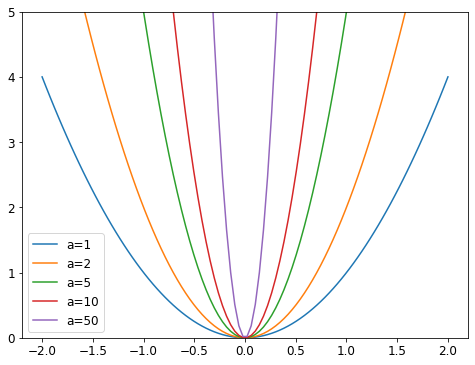

In [ ]:
#hide_input
#id parabolas
x = np.linspace(-2,2,100)
a_s = [1,2,5,10,50] 
ys = [a * x**2 for a in a_s]
_,ax = plt.subplots(figsize=(8,6))
for a,y in zip(a_s,ys): ax.plot(x,y, label=f'a={a}')
ax.set_ylim([0,5])
ax.legend();

So, letting our model learn high parameters might cause it to fit all the data points in the training set with an overcomplex function that has very sharp changes, which will lead to overfitting.

Limiting our weights from growing too much is going to hinder the training of the model, but it will yield a state where it generalizes better. Going back to the theory briefly, weight decay (or just `wd`) is a parameter that controls that sum of squares we add to our loss (assuming `parameters` is a tensor of all parameters):

``` python
loss_with_wd = loss + wd * (parameters**2).sum()
```

In practice, though, it would be very inefficient (and maybe numerically unstable) to compute that big sum and add it to the loss. If you remember a little bit of high school math, you might recall that the derivative of `p**2` with respect to `p` is `2*p`, so adding that big sum to our loss is exactly the same as doing:

``` python
parameters.grad += wd * 2 * parameters
```

In practice, since `wd` is a parameter that we choose, we can just make it twice as big, so we don't even need the `*2` in this equation. To use weight decay in fastai, just pass `wd` in your call to `fit` or `fit_one_cycle`:

In [45]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.936786,0.948972,00:11
1,0.886584,0.869033,00:10
2,0.733325,0.823200,00:10
3,0.573985,0.811938,00:10
4,0.467395,0.812575,00:10


Much better!

In [55]:
from torch.optim import _functional as f

In [57]:
f.adamw??

### Creating Our Own Embedding Module

So far, we've used `Embedding` without thinking about how it really works. Let's re-create `DotProductBias` *without* using this class. We'll need a randomly initialized weight matrix for each of the embeddings. We have to be careful, however. Recall from <<chapter_mnist_basics>> that optimizers require that they can get all the parameters of a module from the module's `parameters` method. However, this does not happen fully automatically. If we just add a tensor as an attribute to a `Module`, it will not be included in `parameters`:

In [58]:
class T(Module):
    def __init__(self): self.a = torch.ones(3)

L(T().parameters())

(#0) []

To tell `Module` that we want to treat a tensor as a parameter, we have to wrap it in the `nn.Parameter` class. This class doesn't actually add any functionality (other than automatically calling `requires_grad_` for us). It's only used as a "marker" to show what to include in `parameters`:

In [59]:
class T(Module):
    def __init__(self): self.a = nn.Parameter(torch.ones(3))

L(T().parameters())

(#1) [Parameter containing:
tensor([1., 1., 1.], requires_grad=True)]

All PyTorch modules use `nn.Parameter` for any trainable parameters, which is why we haven't needed to explicitly use this wrapper up until now:

In [60]:
class T(Module):
    def __init__(self): self.a = nn.Linear(1, 3, bias=False)

t = T()
L(t.parameters())

(#1) [Parameter containing:
tensor([[-0.2983],
        [ 0.7105],
        [ 0.8141]], requires_grad=True)]

In [61]:
type(t.a.weight)

torch.nn.parameter.Parameter

We can create a tensor as a parameter, with random initialization, like so:

In [62]:
def create_params(size):
    return nn.Parameter(torch.zeros(*size).normal_(0, 0.01))

Let's use this to create `DotProductBias` again, but without `Embedding`:

In [63]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = create_params([n_users, n_factors])
        self.user_bias = create_params([n_users])
        self.movie_factors = create_params([n_movies, n_factors])
        self.movie_bias = create_params([n_movies])
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors[x[:,0]]
        movies = self.movie_factors[x[:,1]]
        res = (users*movies).sum(dim=1)
        res += self.user_bias[x[:,0]] + self.movie_bias[x[:,1]]
        return sigmoid_range(res, *self.y_range)

Then let's train it again to check we get around the same results we saw in the previous section:

In [64]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.964866,0.947346,00:10
1,0.834986,0.868344,00:10
2,0.710574,0.828739,00:10
3,0.577509,0.818108,00:10
4,0.457953,0.818832,00:10


Now, let's take a look at what our model has learned.

## Interpreting Embeddings and Biases

Our model is already useful, in that it can provide us with movie recommendations for our users—but it is also interesting to see what parameters it has discovered. The easiest to interpret are the biases. Here are the movies with the lowest values in the bias vector:

In [65]:
movie_bias = learn.model.movie_bias.squeeze()
idxs = movie_bias.argsort()[:5]
[dls.classes['title'][i] for i in idxs]

['Children of the Corn: The Gathering (1996)',
 'Lawnmower Man 2: Beyond Cyberspace (1996)',
 'Vampire in Brooklyn (1995)',
 'Cable Guy, The (1996)',
 'Amityville II: The Possession (1982)']

Think about what this means. What it's saying is that for each of these movies, even when a user is very well matched to its latent factors (which, as we will see in a moment, tend to represent things like level of action, age of movie, and so forth), they still generally don't like it. We could have simply sorted the movies directly by their average rating, but looking at the learned bias tells us something much more interesting. It tells us not just whether a movie is of a kind that people tend not to enjoy watching, but that people tend not to like watching it even if it is of a kind that they would otherwise enjoy! By the same token, here are the movies with the highest bias:

In [66]:
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['L.A. Confidential (1997)',
 "Schindler's List (1993)",
 'Shawshank Redemption, The (1994)',
 'Silence of the Lambs, The (1991)',
 'Star Wars (1977)']

So, for instance, even if you don't normally enjoy detective movies, you might enjoy *LA Confidential*!

It is not quite so easy to directly interpret the embedding matrices. There are just too many factors for a human to look at. But there is a technique that can pull out the most important underlying *directions* in such a matrix, called *principal component analysis* (PCA). We will not be going into this in detail in this book, because it is not particularly important for you to understand to be a deep learning practitioner, but if you are interested then we suggest you check out the fast.ai course [Computational Linear Algebra for Coders](https://github.com/fastai/numerical-linear-algebra). <<img_pca_movie>> shows what our movies look like based on two of the strongest PCA components.

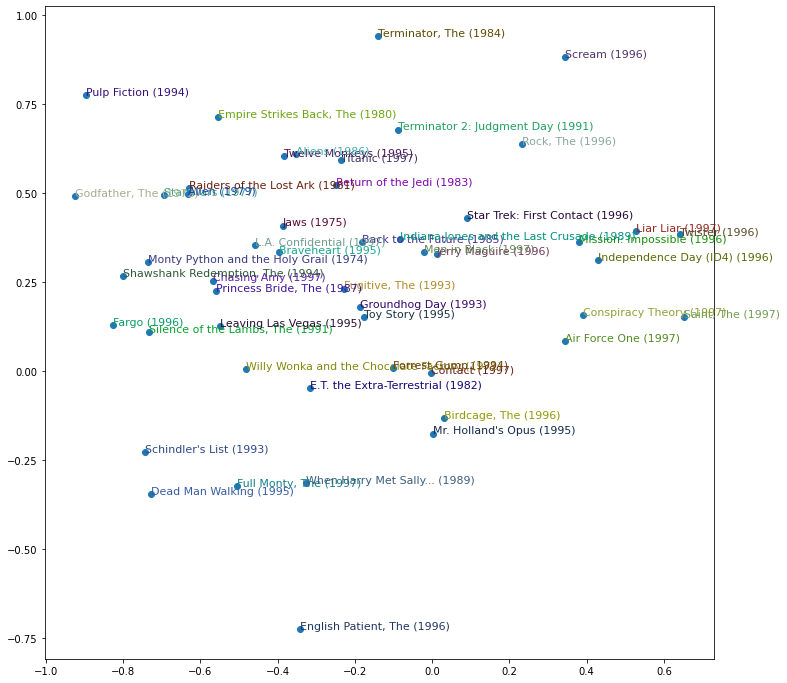

In [67]:
#hide_input
#id img_pca_movie
#caption Representation of movies based on two strongest PCA components
#alt Representation of movies based on two strongest PCA components
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])
movie_w = learn.model.movie_factors[top_idxs].cpu().detach()
movie_pca = movie_w.pca(3)
fac0,fac1,fac2 = movie_pca.t()
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

We can see here that the model seems to have discovered a concept of *classic* versus *pop culture* movies, or perhaps it is *critically acclaimed* that is represented here.

> j: No matter how many models I train, I never stop getting moved and surprised by how these randomly initialized bunches of numbers, trained with such simple mechanics, manage to discover things about my data all by themselves. It almost seems like cheating, that I can create code that does useful things without ever actually telling it how to do those things!

We defined our model from scratch to teach you what is inside, but you can directly use the fastai library to build it. We'll look at how to do that next.

### Using fastai.collab

We can create and train a collaborative filtering model using the exact structure shown earlier by using fastai's `collab_learner`:

In [68]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

In [69]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.983383,0.937107,00:11
1,0.851989,0.866545,00:11
2,0.728751,0.827100,00:11
3,0.586601,0.812165,00:11
4,0.476741,0.813505,00:11


The names of the layers can be seen by printing the model:

In [70]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 50)
  (i_weight): Embedding(1665, 50)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1665, 1)
)

We can use these to replicate any of the analyses we did in the previous section—for instance:

In [71]:
movie_bias = learn.model.i_bias.weight.squeeze()
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

["Schindler's List (1993)",
 'L.A. Confidential (1997)',
 'Star Wars (1977)',
 'Titanic (1997)',
 'Shawshank Redemption, The (1994)']

Another interesting thing we can do with these learned embeddings is to look at _distance_.

### Embedding Distance

On a two-dimensional map we can calculate the distance between two coordinates using the formula of Pythagoras: $\sqrt{x^{2}+y^{2}}$ (assuming that *x* and *y* are the distances between the coordinates on each axis). For a 50-dimensional embedding we can do exactly the same thing, except that we add up the squares of all 50 of the coordinate distances.

If there were two movies that were nearly identical, then their embedding vectors would also have to be nearly identical, because the users that would like them would be nearly exactly the same. There is a more general idea here: movie similarity can be defined by the similarity of users that like those movies. And that directly means that the distance between two movies' embedding vectors can define that similarity. We can use this to find the most similar movie to *Silence of the Lambs*:

In [85]:
movie_factors = learn.model.i_weight.weight
# idx = dls.classes['title'].o2i['Silence of the Lambs, The (1991)']
# idx = dls.classes['title'].o2i['Pulp Fiction (1994)']
idx = dls.classes['title'].o2i['Top Gun (1986)']
distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])
idx = distances.argsort(descending=True)[:5]
for i in idx:
    display(dls.classes['title'][i])

'Top Gun (1986)'

'Pretty Woman (1990)'

'Daylight (1996)'

'American President, The (1995)'

'City of Angels (1998)'

Now that we have succesfully trained a model, let's see how to deal with the situation where we have no data for a user. How can we make recommendations to new users?

## Bootstrapping a Collaborative Filtering Model

The biggest challenge with using collaborative filtering models in practice is the *bootstrapping problem*. The most extreme version of this problem is when you have no users, and therefore no history to learn from. What products do you recommend to your very first user?

But even if you are a well-established company with a long history of user transactions, you still have the question: what do you do when a new user signs up? And indeed, what do you do when you add a new product to your portfolio? There is no magic solution to this problem, and really the solutions that we suggest are just variations of *use your common sense*. You could assign new users the mean of all of the embedding vectors of your other users, but this has the problem that that particular combination of latent factors may be not at all common (for instance, the average for the science-fiction factor may be high, and the average for the action factor may be low, but it is not that common to find people who like science-fiction without action). Better would probably be to pick some particular user to represent *average taste*.

Better still is to use a tabular model based on user meta data to construct your initial embedding vector. When a user signs up, think about what questions you could ask them that could help you to understand their tastes. Then you can create a model where the dependent variable is a user's embedding vector, and the independent variables are the results of the questions that you ask them, along with their signup metadata. We will see in the next section how to create these kinds of tabular models. (You may have noticed that when you sign up for services such as Pandora and Netflix, they tend to ask you a few questions about what genres of movie or music you like; this is how they come up with your initial collaborative filtering recommendations.)

One thing to be careful of is that a small number of extremely enthusiastic users may end up effectively setting the recommendations for your whole user base. This is a very common problem, for instance, in movie recommendation systems. People that watch anime tend to watch a whole lot of it, and don't watch very much else, and spend a lot of time putting their ratings on websites. As a result, anime tends to be heavily overrepresented in a lot of *best ever movies* lists. In this particular case, it can be fairly obvious that you have a problem of representation bias, but if the bias is occurring in the latent factors then it may not be obvious at all.

Such a problem can change the entire makeup of your user base, and the behavior of your system. This is particularly true because of positive feedback loops. If a small number of your users tend to set the direction of your recommendation system, then they are naturally going to end up attracting more people like them to your system. And that will, of course, amplify the original representation bias. This type of bias has a natural tendency to be amplified exponentially. You may have seen examples of company executives expressing surprise at how their online platforms rapidly deteriorated in such a way that they expressed values at odds with the values of the founders. In the presence of these kinds of feedback loops, it is easy to see how such a divergence can happen both quickly and in a way that is hidden until it is too late.

In a self-reinforcing system like this, we should probably expect these kinds of feedback loops to be the norm, not the exception. Therefore, you should assume that you will see them, plan for that, and identify up front how you will deal with these issues. Try to think about all of the ways in which feedback loops may be represented in your system, and how you might be able to identify them in your data. In the end, this is coming back to our original advice about how to avoid disaster when rolling out any kind of machine learning system. It's all about ensuring that there are humans in the loop; that there is careful monitoring, and a gradual and thoughtful rollout.

Our dot product model works quite well, and it is the basis of many successful real-world recommendation systems. This approach to collaborative filtering is known as *probabilistic matrix factorization* (PMF). Another approach, which generally works similarly well given the same data, is deep learning.

In [131]:
mv_emb_idx = np.array(list(dls.classes['title'].o2i[i] for i in movies_full.title))

In [135]:
latent_arr = movie_factors.detach().numpy()[mv_emb_idx]

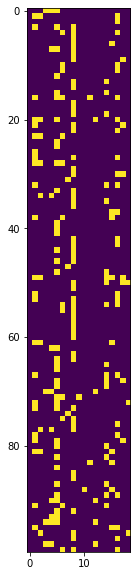

In [165]:
genre_nh = movies_full[gcolumns].values
genre_nh
plt.figure(figsize=(10,10))
plt.imshow(genre_nh[:100])

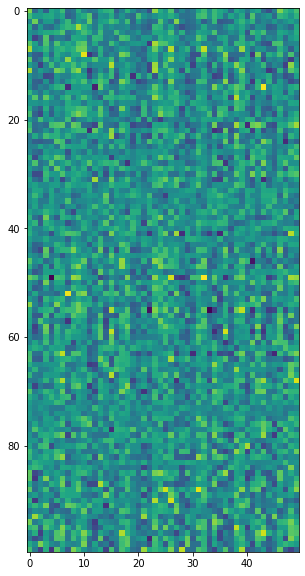

In [137]:
plt.figure(figsize=(10,10))
plt.imshow(latent_arr[:100])

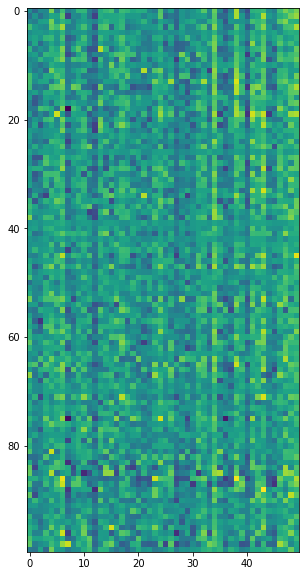

In [140]:
plt.figure(figsize=(10,10))
plt.imshow(movie_factors[distances.argsort(descending=True)[:100]].detach().numpy())

In [191]:
from torch.utils.data.dataset import Dataset
from fastai.data.core import DataLoaders

class ColdBS(Dataset):
    def __init__(self, genre_array, latent_array):
        self.genre = genre_array
        self.latent = latent_array
        assert len(genre_array)==len(latent_array), "2 sets of data not equally populated"
        
    def __len__(self, ):
        return len(self.genre)

    def __getitem__(self, idx):
        return self.genre[idx].astype(dtype=np.float32),self.latent[idx]

This is not a very scientific way of creating train/test split

In [198]:
cold_bs_train = ColdBS(genre_nh[:1600], latent_arr[:1600])
cold_bs_valid = ColdBS(genre_nh[1600:], latent_arr[1600:])

In [199]:
dls2 = DataLoaders.from_dsets(cold_bs_train, cold_bs_valid)

In [200]:
genre_nh.shape, latent_arr.shape

((1664, 19), (1664, 50))

In [201]:
class HardCodedGenre2Latent(nn.Module):
    def __init__(self, in_, out_, hs=64):
        super().__init__()
        self.mlp = nn.Sequential(*[
            nn.Linear(in_, hs, bias=False),
            nn.BatchNorm1d(hs),
            nn.ReLU(),
            nn.Linear(hs, out_)
        ])

    def forward(self, x):
        return self.mlp(x)


In [207]:
hard2latent = HardCodedGenre2Latent(genre_nh.shape[1], latent_arr.shape[1])
learner2 = Learner(dls2, hard2latent, loss_func=nn.MSELoss(),)

In [208]:
learner2.fit_one_cycle(10, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.119196,0.012673,00:00
1,0.068142,0.008638,00:00
2,0.044162,0.005673,00:00
3,0.032312,0.005743,00:00
4,0.025826,0.005104,00:00
5,0.022006,0.004956,00:00
6,0.019592,0.004547,00:00
7,0.018094,0.004762,00:00
8,0.017128,0.004525,00:00
9,0.016484,0.004622,00:00


In [211]:
hard2latent = hard2latent.eval()
big_i = torch.eye(len(genre_map))
with torch.no_grad():
    all_g = torch.stack(list(big_i[i] for i,g in genre_map.items()))
    yhat_latent = hard2latent(all_g)

In [219]:
movies_full["movie"] = range(len(movies_full))

In [225]:
movies_full[movies_full.title.str.contains('Top Gun')]

,movie,title,date,genre_unknown,genre_Action,genre_Adventure,genre_Animation,genre_Children's,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Fantasy,genre_Film-Noir,genre_Horror,genre_Musical,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_War,genre_Western
160,160,Top Gun (1986),01-Jan-1986,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


### Expore distances back to genre

In [226]:
idx = dls.classes['title'].o2i['Top Gun (1986)']
distances = nn.CosineSimilarity(dim=1)(yhat_latent, movie_factors[idx][None])
idx = distances.argsort(descending=True)
for i in idx:
    display(genre_map[i.item()])

'Western'

'Thriller'

'Musical'

'Action'

'Romance'

'Drama'

'War'

'Adventure'

'Animation'

'Documentary'

'Comedy'

'Horror'

'Crime'

'Film-Noir'

"Children's"

'Sci-Fi'

'Mystery'

'unknown'

'Fantasy'

In [235]:
from sklearn.decomposition import PCA

In [238]:
pca = PCA(2)
glatent_2d = pca.fit_transform(yhat_latent.numpy())

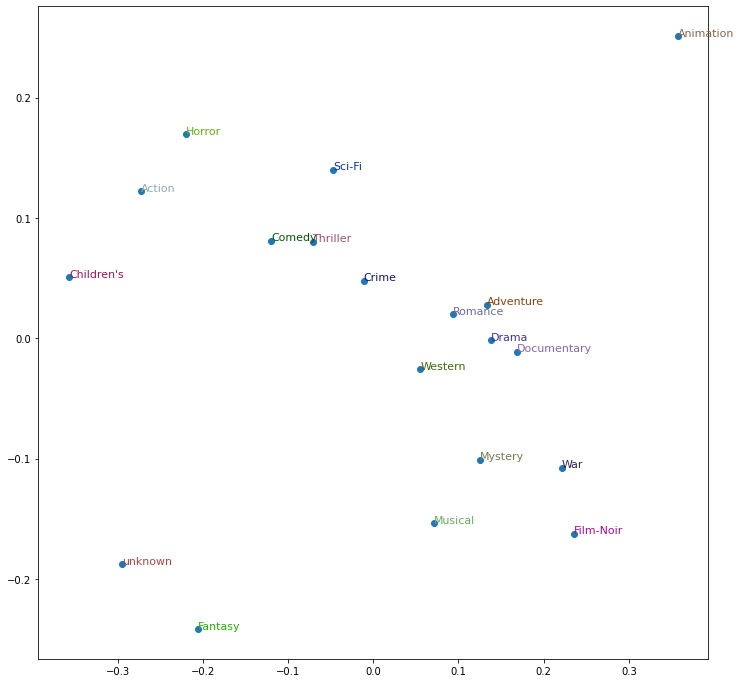

In [239]:
X = glatent_2d[:,0]
Y = glatent_2d[:,1]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(genre_map.values(), X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

## Deep Learning for Collaborative Filtering

To turn our architecture into a deep learning model, the first step is to take the results of the embedding lookup and concatenate those activations together. This gives us a matrix which we can then pass through linear layers and nonlinearities in the usual way.

Since we'll be concatenating the embeddings, rather than taking their dot product, the two embedding matrices can have different sizes (i.e., different numbers of latent factors). fastai has a function `get_emb_sz` that returns recommended sizes for embedding matrices for your data, based on a heuristic that fast.ai has found tends to work well in practice:

In [ ]:
embs = get_emb_sz(dls)
embs

[(944, 74), (1635, 101)]

Let's implement this class:

In [ ]:
class CollabNN(Module):
    def __init__(self, user_sz, item_sz, y_range=(0,5.5), n_act=100):
        self.user_factors = Embedding(*user_sz)
        self.item_factors = Embedding(*item_sz)
        self.layers = nn.Sequential(
            nn.Linear(user_sz[1]+item_sz[1], n_act),
            nn.ReLU(),
            nn.Linear(n_act, 1))
        self.y_range = y_range
        
    def forward(self, x):
        embs = self.user_factors(x[:,0]),self.item_factors(x[:,1])
        x = self.layers(torch.cat(embs, dim=1))
        return sigmoid_range(x, *self.y_range)

And use it to create a model:

In [ ]:
model = CollabNN(*embs)

`CollabNN` creates our `Embedding` layers in the same way as previous classes in this chapter, except that we now use the `embs` sizes. `self.layers` is identical to the mini-neural net we created in <<chapter_mnist_basics>> for MNIST. Then, in `forward`, we apply the embeddings, concatenate the results, and pass this through the mini-neural net. Finally, we apply `sigmoid_range` as we have in previous models.

Let's see if it trains:

In [ ]:
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.01)

epoch,train_loss,valid_loss,time
0,0.940104,0.959786,00:15
1,0.893943,0.905222,00:14
2,0.865591,0.875238,00:14
3,0.800177,0.867468,00:14
4,0.760255,0.867455,00:14


fastai provides this model in `fastai.collab` if you pass `use_nn=True` in your call to `collab_learner` (including calling `get_emb_sz` for you), and it lets you easily create more layers. For instance, here we're creating two hidden layers, of size 100 and 50, respectively:

In [ ]:
learn = collab_learner(dls, use_nn=True, y_range=(0, 5.5), layers=[100,50])
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,1.002747,0.972392,00:16
1,0.926903,0.922348,00:16
2,0.877160,0.893401,00:16
3,0.838334,0.865040,00:16
4,0.781666,0.864936,00:16


`learn.model` is an object of type `EmbeddingNN`. Let's take a look at fastai's code for this class:

In [ ]:
@delegates(TabularModel)
class EmbeddingNN(TabularModel):
    def __init__(self, emb_szs, layers, **kwargs):
        super().__init__(emb_szs, layers=layers, n_cont=0, out_sz=1, **kwargs)

Wow, that's not a lot of code! This class *inherits* from `TabularModel`, which is where it gets all its functionality from. In `__init__` it calls the same method in `TabularModel`, passing `n_cont=0` and `out_sz=1`; other than that, it only passes along whatever arguments it received.

### Sidebar: kwargs and Delegates

`EmbeddingNN` includes `**kwargs` as a parameter to `__init__`. In Python `**kwargs` in a parameter list means "put any additional keyword arguments into a dict called `kwargs`. And `**kwargs` in an argument list means "insert all key/value pairs in the `kwargs` dict as named arguments here". This approach is used in many popular libraries, such as `matplotlib`, in which the main `plot` function simply has the signature `plot(*args, **kwargs)`. The [`plot` documentation](https://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.plot) says "The `kwargs` are `Line2D` properties" and then lists those properties.

We're using `**kwargs` in `EmbeddingNN` to avoid having to write all the arguments to `TabularModel` a second time, and keep them in sync. However, this makes our API quite difficult to work with, because now Jupyter Notebook doesn't know what parameters are available. Consequently things like tab completion of parameter names and pop-up lists of signatures won't work.

fastai resolves this by providing a special `@delegates` decorator, which automatically changes the signature of the class or function (`EmbeddingNN` in this case) to insert all of its keyword arguments into the signature.

### End sidebar

Although the results of `EmbeddingNN` are a bit worse than the dot product approach (which shows the power of carefully constructing an architecture for a domain), it does allow us to do something very important: we can now directly incorporate other user and movie information, date and time information, or any other information that may be relevant to the recommendation. That's exactly what `TabularModel` does. In fact, we've now seen that `EmbeddingNN` is just a `TabularModel`, with `n_cont=0` and `out_sz=1`. So, we'd better spend some time learning about `TabularModel`, and how to use it to get great results! We'll do that in the next chapter.

## Conclusion

For our first non-computer vision application, we looked at recommendation systems and saw how gradient descent can learn intrinsic factors or biases about items from a history of ratings. Those can then give us information about the data. 

We also built our first model in PyTorch. We will do a lot more of this in the next section of the book, but first, let's finish our dive into the other general applications of deep learning, continuing with tabular data.

## Questionnaire

1. What problem does collaborative filtering solve?
1. How does it solve it?
1. Why might a collaborative filtering predictive model fail to be a very useful recommendation system?
1. What does a crosstab representation of collaborative filtering data look like?
1. Write the code to create a crosstab representation of the MovieLens data (you might need to do some web searching!).
1. What is a latent factor? Why is it "latent"?
1. What is a dot product? Calculate a dot product manually using pure Python with lists.
1. What does `pandas.DataFrame.merge` do?
1. What is an embedding matrix?
1. What is the relationship between an embedding and a matrix of one-hot-encoded vectors?
1. Why do we need `Embedding` if we could use one-hot-encoded vectors for the same thing?
1. What does an embedding contain before we start training (assuming we're not using a pretained model)?
1. Create a class (without peeking, if possible!) and use it.
1. What does `x[:,0]` return?
1. Rewrite the `DotProduct` class (without peeking, if possible!) and train a model with it.
1. What is a good loss function to use for MovieLens? Why? 
1. What would happen if we used cross-entropy loss with MovieLens? How would we need to change the model?
1. What is the use of bias in a dot product model?
1. What is another name for weight decay?
1. Write the equation for weight decay (without peeking!).
1. Write the equation for the gradient of weight decay. Why does it help reduce weights?
1. Why does reducing weights lead to better generalization?
1. What does `argsort` do in PyTorch?
1. Does sorting the movie biases give the same result as averaging overall movie ratings by movie? Why/why not?
1. How do you print the names and details of the layers in a model?
1. What is the "bootstrapping problem" in collaborative filtering?
1. How could you deal with the bootstrapping problem for new users? For new movies?
1. How can feedback loops impact collaborative filtering systems?
1. When using a neural network in collaborative filtering, why can we have different numbers of factors for movies and users?
1. Why is there an `nn.Sequential` in the `CollabNN` model?
1. What kind of model should we use if we want to add metadata about users and items, or information such as date and time, to a collaborative filtering model?

### Further Research

1. Take a look at all the differences between the `Embedding` version of `DotProductBias` and the `create_params` version, and try to understand why each of those changes is required. If you're not sure, try reverting each change to see what happens. (NB: even the type of brackets used in `forward` has changed!)
1. Find three other areas where collaborative filtering is being used, and find out what the pros and cons of this approach are in those areas.
1. Complete this notebook using the full MovieLens dataset, and compare your results to online benchmarks. See if you can improve your accuracy. Look on the book's website and the fast.ai forum for ideas. Note that there are more columns in the full dataset—see if you can use those too (the next chapter might give you ideas).
1. Create a model for MovieLens that works with cross-entropy loss, and compare it to the model in this chapter.